Import packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load processed weekly RKI data

In [2]:
rki_weekly = pd.read_csv('rki_weekly.csv')

Create weekly reproduction factors and shifted and logarithmized versions:

In [3]:
one_as_default = True #False would turn div-by-zero and zero R0s into NaNs
#model performance decreases when False, but distribution of target has less of
#a spike at 0. Still, having gap-less panel data is better.

rki_weekly['infs_last_week'] = rki_weekly.groupby('districtId')['AnzahlFall'].shift(1)

if one_as_default:
    rki_weekly['R0_last_week'] = (rki_weekly['AnzahlFall'] + 1) / (rki_weekly['infs_last_week'] + 1)
else:
    rki_weekly['R0_last_week'] = (rki_weekly['AnzahlFall']) / (rki_weekly['infs_last_week'])
    rki_weekly['R0_last_week'].replace([np.inf, 0],np.nan,inplace=True)

rki_weekly['R0_this_week'] = rki_weekly.groupby('districtId')['R0_last_week'].shift(-1)
rki_weekly['ar2_'] = rki_weekly.groupby('districtId')['R0_last_week'].shift(1)
# rki_weekly['ar3_'] = rki_weekly.groupby('districtId')['R0_last_week'].shift(2)
# rki_weekly['ar4_'] = rki_weekly.groupby('districtId')['R0_last_week'].shift(3)

rki_weekly['target'] = np.log(rki_weekly['R0_this_week'])
rki_weekly['auto_regr'] = np.log(rki_weekly['R0_last_week'])
rki_weekly['auto_regr2'] = np.log(rki_weekly['ar2_'])
# rki_weekly['auto_regr3'] = np.log(rki_weekly['ar3_'])
# rki_weekly['auto_regr4'] = np.log(rki_weekly['ar4_'])

Load in feature data:

In [4]:
static_data = pd.read_csv('processed_static_data.csv')
mobility_features = pd.read_csv('mobility_features.csv')
weather_features = pd.read_csv('weather_features.csv')
all_data = rki_weekly.merge(static_data).merge(mobility_features[mobility_features.year==2020]).merge(weather_features)

Differentiating between day off and workday mobility features not productive as they correlate too highly anyway. I reverse it here, instead of in the feature creation, mostly due to the fact that new mobility feature creation would entail more beaurocracy.

In [5]:
features_to_resum = ['Count_internal','Count_incoming']

for f in features_to_resum:
    for p in ['','_p_pop']:
        var_work = f + '_workday' + p
        var_off = f + '_day_off' + p
        all_data[f + p] = all_data[var_work] + all_data[var_off]

Timeseries features get used twice, once as is, once shifted back by one week, effectively creating an ARX(2,2) model:

In [6]:
vars_2_lag = ['Count_internal',
       'Count_incoming', 'incoming_infected',
       'Count_internal_p_pop',
       'Count_incoming_p_pop',
       'incoming_infected_p_pop',
       'temperature', 'humidity', 'precipitation',
       'sunshine', 'velocity',
        'Count_internal_workday', 'Count_internal_day_off',
       'Count_incoming_workday', 'Count_incoming_day_off', 
       'Count_internal_workday_p_pop', 'Count_internal_day_off_p_pop',
       'Count_incoming_workday_p_pop', 'Count_incoming_day_off_p_pop',
       'temperature_workday', 'humidity_workday', 'precipitation_workday',
       'sunshine_workday', 'velocity_workday', 'direction_workday',
       'temperature_day_off', 'humidity_day_off', 'precipitation_day_off',
       'sunshine_day_off', 'velocity_day_off', 'direction_day_off']


for var in vars_2_lag:
    var_name = var + '_lag1'
    all_data[var_name] = all_data.groupby('districtId')[var].shift(1)
    
    
#additional 2 week lag no benefit at all:
#     var_name = var + '_lag2'
#     all_data[var_name] = all_data.groupby('districtId')[var].shift(2)
#Thus, for exogenous influences, I take the original timeseries, and
#the one-lagged, but no more.
    

Here, we slice away the early weeks where there were too few cases, and the later weeks, which are outside our study's set scope:

In [7]:
FIRST_WEEK = 12
LAST_WEEK = 38

all_data = all_data[all_data.week_no.between(FIRST_WEEK, LAST_WEEK)]

Next, the cross-prediction function, which has as many decision parametrized as possible. See in-function description for details:

In [8]:
def cross_predict(data, how, model, X_cols, y_col, id_col = None, shuffle_mode = 'id', mod_params = None, mod_attrs_2_return = None, z_trim = None, random_state = 1):
    
    '''Function to cross-predict target variable across multiple groups.
    Parameters:
    data = Dataframe containing at least X_cols, y_col and the same (multi-)index as intended for the output, additional columns are dropped. Rows with missing values in any relevant column are dropped as well.
    how = Either number of groups for cross-validation or string 's'/'student_resid' for studentized residuals, i.e. each observation as its own group, predicted by a model fitted on all data except the observation itself. Can be arbitrarily high, even higher than N of data, with resulting empty groups ignored. Setting \'how\'' to 1 omits cross-prediction, and fits and uses the model on the entire or only z-trimmed data set instead.
    model = String corresponding to the name of an already imported model class. Only classes with .fit() and .predict() methods will work.
    X_col = List of column names used as features in target prediction
    y_col = Column name of target variable
    id_col = Single column name or list of column names needed for re-merging the results to other dataframes. If None, the dataframe index, passed through from the data input, can still be used
    shuffle_mode = 'id': all values with the same ID are in the same group. 'full': every data point is shuffled independently, so that e.g. the same district can have weekly values in the training set and the prediction set.
    mod_params = optional dictionary with named parameters for the model, e.g. max_depth for RF. The function's random state is passed as random_state parameter automatically.
    mod_attrs_2_return = String name or list of names of attributes of the fitted model objects to return, e.g. 'coef_' for linear regression weights. Returns a dictionary with attribute name(s) as key(s) and corresponding list of attribute values as value(s).
    z_trim = optional threshold for extreme outliers to be removed from training data, to avoid overfitting on these outliers. All observations with target values with a z-score above this value will be dropped from the training data. Does not affect test data, so that potential positive deviance can still be found without hurting the model.
    random_state = seed for RandomState object used in all RNG processes for re-producible results.
    
    Returns:
    output_df = Dataframe containing predicted target values, actual target values and grouping IDs from the cross-prediction process. Indexed with the same variables as the data input.
    accuracies = Dictionary with overall_R2, training_accuriacies and, if more than one value is predicted per iteration, the resulting out_of_sample_accuracies.
    mod_attrs = dictionary of lists with the requested model attributes to return, keyed with the attribute name. Empty dictionary if mod_attrs_2_return is None.
    
    Note: Function is written for model objects with sklearn syntax, e.g. initializing without arguments, fitting in place.
    Statsmodels uses different syntax, initializing with endogenous and exogenous variables, returning the fitted model. Instead of writing exception handling for all that, it's easier to just write an sklearn-esque version of the Statsmodels function if need be, like here for ordinary least squares regression:
    
    import statsmodels.api as sm
    class sm_ols():
    def __init__(self):
        pass
    
    def fit(self,X,y):
        X = sm.add_constant(X)
        self.mod = sm.OLS(y,X).fit()
        
    def predict(self,X):
        X = sm.add_constant(X)
        predictions = self.mod.predict(X)
        return predictions
    
    '''
    
    from sklearn.metrics import r2_score, mean_absolute_error
    
    if id_col is not None:
        all_cols = pd.core.common.flatten([X_cols,y_col,id_col]) #flatten, since X and id can 
    else:  #be either one string or a list of strings
        all_cols = pd.core.common.flatten([X_cols,y_col])
    df = data[all_cols].copy() #drop columns not needed
    df.dropna(axis=0, inplace=True) #rowwise delete NAs 
    X = df[X_cols] #select predictors
    y = df[y_col] #select target
    n = df.shape[0] #get sample size (after NA removal)
    rand = np.random.RandomState(random_state) #init random state
    
    train_accs = [] #init list of individual training accuracies
    test_accs = [] #init list of individual test accuracies
    mod_attrs = {}
    if mod_attrs_2_return is not None: #init output for model attributes
        if type(mod_attrs_2_return) == str: #if a single attribute name string,
            mod_attrs[mod_attrs_2_return]=[] #the function will output a list of these attribute values
        else: #else, we'll assume an iterable input, where each attribute will be
            #used as the key in a dictionary of lists
            for a in mod_attrs_2_return: #of attribute values that is initialised emptily
                mod_attrs[a] = [] #here.
    
    output_df = pd.DataFrame() #init dataframe for output
    pred_var_name = y_col + '_predicted' #define name for predicted target variable
    
    if shuffle_mode == 'full':#every row of the dataframe is treated independently
        if how == 'student_resid' or how == 's': #if studentized residuals are wanted, 
            group = np.arange(n) #each observation is its own group
        else:
            try: #otherwise assign to specified number of groups
                group = np.arange(n) % how
                rand.shuffle(group) #shuffle to avoid e.g. Bundesland effects due to districtId            
            except: #catch all cases where this fails (i.e. non-int, non-positive)
                #demanding more groups than cases is not problematic, since some groups will be empty and thus ignored,
                #so they are not caught here
                raise ValueError('Parameter \'how\' needs to be positive integer or \'student_resid\' or \'s\'')
    elif shuffle_mode == 'id': #all values of one id must be in the same group
        if id_col is None:
            raise ValueError('No ID cols to shuffle with!')
        else:
            unique_IDs = pd.DataFrame(df.groupby(id_col).size().reset_index()[id_col]) 
            #this gets all unique ID values for a single string, as well as all unique combinations for a list of strings
            n_uniq = unique_IDs.shape[0] #number of unique ID(combination)s as length of group column to be created
            
            if how =='student_resid' or how == 's':
                ID_group = np.arange(n_uniq) #each unique ID(combination) gets its own group
            else:
                try: #otherwise assign to specified number of groups
                    ID_group = np.arange(n_uniq) % how
                    rand.shuffle(ID_group) #shuffle to avoid e.g. Bundesland effects due to districtId            
                except: #catch all cases where this fails (i.e. non-int, non-positive)
                #demanding more groups than cases is not problematic, since some groups will be empty and thus ignored,
                #so they are not caught here
                    raise ValueError('Parameter \'how\' needs to be positive integer or \'student_resid\' or \'s\'')
            
            unique_IDs['group'] = ID_group #add group to the dataframe of unique IDs so that
            df_with_group = pd.merge(df, unique_IDs) #we can merge it with the dataframe to get the 
            group = np.array(df_with_group['group']) #array matching each row of the full dataset to its respective group
            
    else:
        raise ValueError('shuffle mode must be either \'id\' or \'full\'!')
            
    for g in np.unique(group):#iterate over groups
        
        if how == 1: #if only one group, 
            X_train, y_train = X, y #train on entire dataset.
            X_test, y_test = X, y #this would happen anyway since all data is in group g=0, included here only as failsafe.
        else:
            X_train = X[group != g] #train model on all data NOT in the group
            y_train = y[group != g]
                
            X_test = X[group == g] #test/predict in group data
            y_test = y[group == g]

            
        if z_trim is not None: #if extreme values should be trimmed from training data
            m_y = np.mean(y_train) #calc train target mean
            s_y = np.std(y_train) #and SD
            z_y = (y_train - m_y) / s_y #for z-values
            X_train = X_train[abs(z_y) <= z_trim] #and cut all observations with target values
            y_train = y_train[abs(z_y) <= z_trim] #more extreme than z_trim threshold
        
        #defining model by trying to pass string input as (previously imported) model class name.
        #Both passing and not passing call brackets will work.
        try: 
            mod = eval(model+'()')
        except:
            try:
                mod = eval(model)
            except:
                raise ValueError('\'model\' parameter could not be interpreted as model class. Check whether you have imported the corresponding class.')

        setattr(mod, 'random_state', rand)#if model uses RNG, passing the function's RandomState object here. Will be passively ignored by e.g. LinearRegression().

        if mod_params is not None: #if model params are provided as a dict
            for k, v in mod_params.items(): #iterate over dict and
                setattr(mod,k,v) #set attributes of mod accordingly
                #meaningless attributes are added without effect, e.g.
                #max_depth for LinearRegression will be set without error
                #because it is simply ignored
        
        mod.fit(X_train, y_train) #fit model to training data
        
        train_accs.append(r2_score(y_train, mod.predict(X_train))) #save model performance for training set
        
        y_pred = mod.predict(X_test) #predict target variable for data in current group
        #this will be the prediction that 'counts' for this data, as it is the only prediction
        #for this data where the model has not seen this data before
        
        if len(y_pred) > 1: #y_pred will be 1 long when studentized residuals are chosen or when groups become too small
            test_accs.append(r2_score(y_test, y_pred)) #if there are enough (2) observations, save test performance as well
        
        group_output = pd.DataFrame({pred_var_name:y_pred, #the predicted target
                                    y_col:y_test, #values, the actual target values and the
                                    'grouping_id':g}) #grouping IDs for potential trouble shooting
        
        if id_col is None: #if no ID columns are supposed to be passed through,
            pass #no action necessary
        elif type(id_col) == str: #alternatively, if one col name string is given,
            group_output[id_col] = df[id_col][group == g] #add this column to group output
        else: #else, id_col is assumed to be iterable (a list). id_cols that are neither strings, nor iterables
            for i in id_col: #will throw a non-iterable error. Here, we iterate over the list and
                group_output[i] = df[i][group == g] #add each col to output
        
        output_df = pd.concat([output_df, group_output]) #add output for current group to overall output
        
        if mod_attrs_2_return is None: #if no mod attributes are wanted,
            pass #no action is necessary
        elif type(mod_attrs_2_return) == str: #if one attribute name string is given,
            mod_attrs[mod_attrs_2_return].append(getattr(mod, mod_attrs_2_return)) #add the current models value to list
        else: #else, input is assumed to be iterable (a list). If neither string, nor iterable, an error is raised about
            for a in mod_attrs_2_return: #it not being iterable. Here, we iterate over the attributes and append
                mod_attrs[a].append(getattr(mod, a)) #each attribute to the right list in the attribute dict
        
    output_df.sort_index(inplace=True)#revert order to index ordering, as it is now sorted by group first
    #If the input dataframe was sorted by its index, this should result in 
    #the same order as the input dataframe, apart from the dropped rows due to missing values.
    total_r2 = r2_score(output_df[y_col],output_df[pred_var_name]) #calc R2 for all data combined
    total_mae = mean_absolute_error(output_df[y_col],output_df[pred_var_name])
    print('Overall, the cross-predictions accounted for {:.2%} of the target variance.'.format(total_r2))
    print('The Mean Absolute Error was {:.5}'.format(total_mae))  
    
    accuracies = {'overall_R2': total_r2,
                 'training_accuracies':train_accs}
    if len(test_accs) > 0:
        accuracies['out_of_sample_accuracies']=test_accs
                                                                                            
    return output_df, accuracies, mod_attrs
    


List of all predictors/features to be used:

In [9]:
predictor_variables = ['auto_regr',
                       'auto_regr2',
                       'Count_internal_p_pop',
                       'Count_internal_p_pop_lag1',
                       'Count_incoming_p_pop',
                       'Count_incoming_p_pop_lag1',
                       'incoming_infected_p_pop',
                       'incoming_infected_p_pop_lag1',
                       'temperature',
                       'temperature_lag1',
                       'humidity',
                       'humidity_lag1',
                       'precipitation',
                       'precipitation_lag1',
                       'sunshine',
                       'sunshine_lag1'
                      ]

Problem: The standard sklearn Huber regression does not yield standardized regression weights, but for deviance purposes, I also don't want to z-standardize my target (or features). Thus, I create a class here that does the standardizing and de-standardizing under the hood.

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import HuberRegressor

class standard_huber():
    def __init__(self, epsilon = 1.35):#1.35 is also the default value in sklearn, and the one proposed by Mr Huber himself
        self.x_sclr = StandardScaler()
        self.y_sclr = StandardScaler()
        self.epsilon = epsilon
    
    def fit(self,X,y):
        self.mod = HuberRegressor(epsilon=self.epsilon)
        X_scld = self.x_sclr.fit_transform(X)
        y_rshp = np.array(y).reshape(-1,1)
        y_scld = self.y_sclr.fit_transform(y_rshp).reshape(-1,)
        self.mod.fit(X_scld,y_scld)
        
    def predict(self,X):
        
        X_scld = self.x_sclr.transform(X)
        pred_y_scld = self.mod.predict(X_scld)
        predictions = self.y_sclr.inverse_transform(pred_y_scld).reshape(-1,)
        
        return predictions
    
    @property
    def coef_(self):
        return self.mod.coef_

Use the cross-prediction:

In [11]:
predictions, accs, mod_attrs = cross_predict(data = all_data,
                                                         X_cols = predictor_variables,
                                                         y_col = 'target',
                                                         id_col = 'districtId',
                                                         how = 's',
                                                         shuffle_mode='id',
                                                         model = 'standard_huber',
                                                         mod_attrs_2_return = 'coef_',
                                                         z_trim = None,
                                                         mod_params={'epsilon':1.35})#see above, 1.35 is default

Overall, the cross-predictions accounted for 14.52% of the target variance.
The Mean Absolute Error was 0.55539


Calculate the deviance, and print the correlation of predicted and actual target values, mostly as a sanity check:

In [12]:
predictions['deviance'] = predictions['target_predicted'] - predictions['target']
print(np.corrcoef(predictions['target_predicted'], predictions['target']))

[[1.         0.38102076]
 [0.38102076 1.        ]]


Merge it all:

In [13]:
all_data = pd.merge(all_data, predictions, left_index=True, right_index=True, suffixes=('','_del')).drop(columns=['districtId_del','target_del'])

Save the data:

In [14]:
all_data.to_csv('all_data.csv',index=False)

### Analyse regression weights 

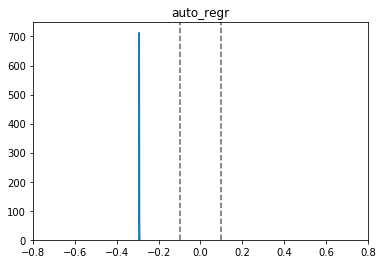

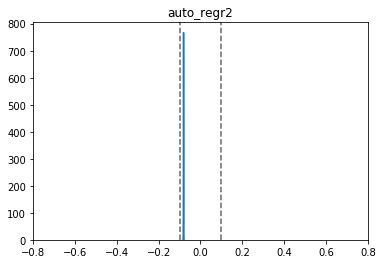

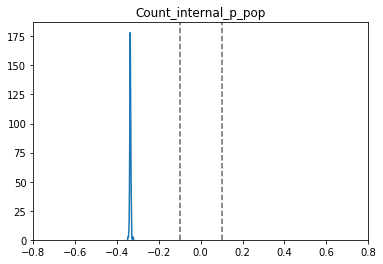

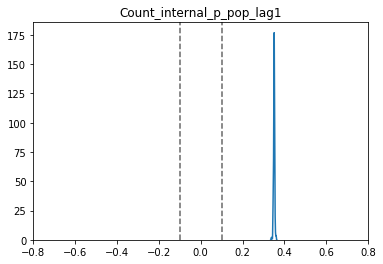

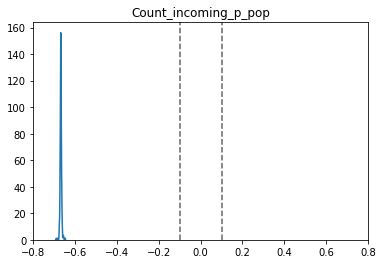

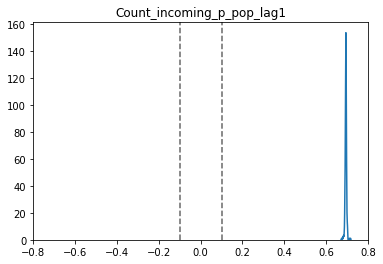

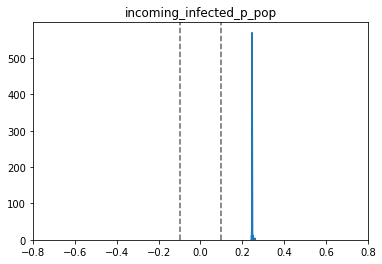

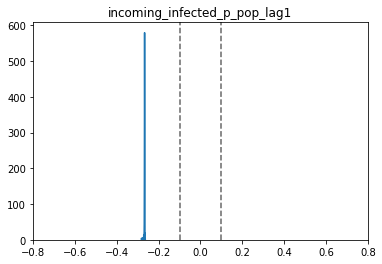

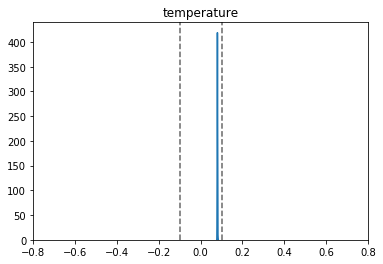

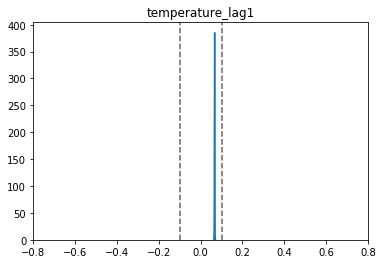

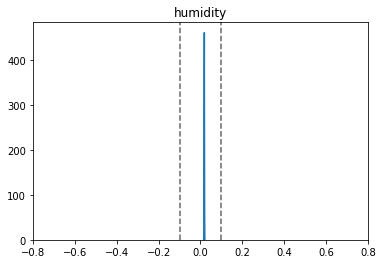

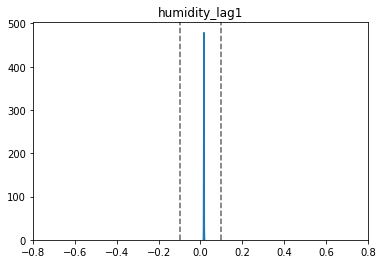

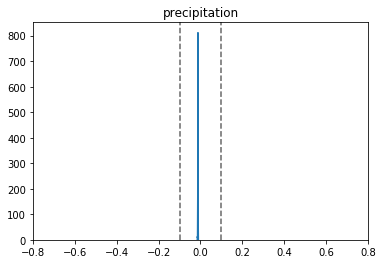

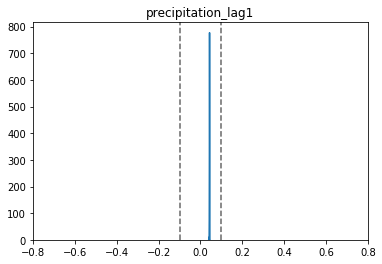

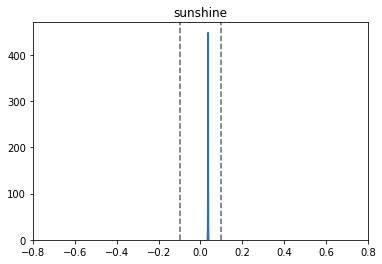

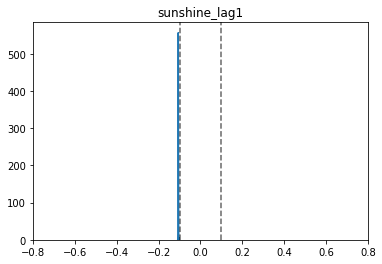

In [15]:
attr_dict = {}
for i, var in enumerate(predictor_variables):
    #print(var)
    attr_dict[var] = []
          
    for a in mod_attrs['coef_']:
        attr_dict[var].append(a[i])
    sns.distplot(attr_dict[var],hist=False)
    plt.title(var)
    plt.axvline(-.1,color='k',linestyle='dashed',alpha=.6)
    plt.axvline(.1,color='k',linestyle='dashed',alpha=.6)
    xlim=.8
    plt.xlim([-xlim,xlim])
    plt.show()


If our model is not corrupted by outliers, there should not be any correlation between any predictor and the deviance:

In [16]:
corr=all_data[predictor_variables+['deviance']].corr()

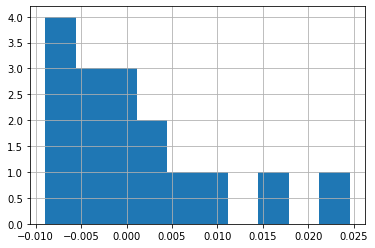

In [17]:
corr.deviance.iloc[:-1].hist()

Plot predicted and actual values against each other. You see the larger spike of zeroes in the target, which mostly result from one being the 'default' value for the reproduction factors, thus leading to logs of zero. Since these don't create variance (mean is about zero), model performance is actually worse when dropping these values, so I'd keep these values, rather than working with a gappy timeseries.

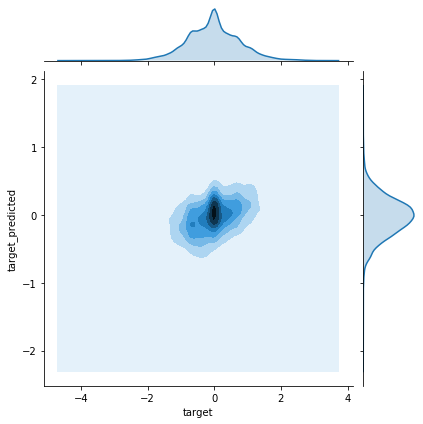

In [18]:
sns.jointplot(predictions.target, predictions.target_predicted,kind='kde')
